*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 1:<br>A simple QML model in PennyLane
<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To explore the process of developing a <strong>PennyLane</strong> quantum model.<br/>Watch out for modeling pits and traps!</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>April 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>Use the following two data sets (code below):<br>
            <ol><li>$y = sin(x)$</li><li>$y = sin(0.7 x+0.5\pi)$</li></ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>Time: 40 minutes (unfinished tasks go to self-directed "challenges").<br>
            All tasks listed in this table have been colour-coded across the notebook.<br>
            To make changes, you will need to hunt for the relevant section.</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks and observe their impact on the model performance.<br>
            (Record your observations at end of this notebook):<br><ol>
            <li>Initially use <strong><em>the first dataset</em></strong> and the <strong><em>simplistic model 1</em></strong> (as provided).<br>
                Follow the instructor demonstration to step through the code.</li>
            <li>Can the model performance be improved by trivial changes, such as:<br>
                - alter the range of model init values ? (reduce "high" for training)</li>
            <li>Can you improve the quantum model by changing the ansatz size, by:<br>
                (you may need to increase the number of epochs):<br>
                - using more qubits or more layers ? (those of you with big computers)<br>
                - using fewer qubits or fewer layers ? (those of you with tiny laptops)</li>
            <li>Can the model work with a single qubit and single layer ?</li>
            <li>Change the data encoding gate from RY to RX ?<br>
                - what happens and why?<br>
                - can the performance be further improved by changing the training epochs?</li>
            <li>Change entangling from basic (R with 1 param) to strong (R with 3 params).<br>
                - what is the reason for the result ?</li><br>
                <em>The tasks below will be demonstrated by your instructor.</em><br>
                <em>However, we would like you to attempt them as challenge tasks.</em><br><br>
            <li>Try the current model with <strong><em>the second data set</em></strong><br>
                by commenting / uncommenting code in Data Generation section<br>
                Can you improve the model performance by varying:<br>
                - the number of qubits ?<br>
                - the number of layers ?<br>
                - by increasing data range (say: -6..12) ?<br>
                - by adding more training data (say: 96) ?</li>
            <li>Can you improve the result by data reuploading, i.e. by implementing: <br>
                - <strong><em>partial reuploading:</em></strong> for all qubits within encoding block, as in <strong><em>model 2</em></strong> ?<br>
                - <strong><em>full reuploading:</em></strong> in between entangling blocks, as in <strong><em>model 3</em></strong> ?</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform the following tasks in your own time:<br/>
        <ol style="list-style-type: upper-alpha;">
            <li>Complete the unfinished tasks.</li>
            <li>Is there a way of improving the model results for <strong><em>the second data set</em></strong> ?<br>
                <em>The answer will be revealed on <strong>day 2</strong> of the workshop !</em></li>
            <li>Experiment with different optimisers and their hyper-parameters.</li>
            <li>Write your own optimiser - see example at the end of the notebook.</li></ol>
        </td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><a href="https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series" target="_blank">
            Maria Schuld and Johannes Jakob Meyer, "Quantum models as Fourier series",<br>PennyLane, November 6, 2024.</a></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook</td></tr>
</table>

## Load the necessary packages
<font color="LightCoral">Task 1: Follow the instructor demonstration to step through the code.</font>

<font color="CornflowerBlue">Note that PennyLane redefines <strong><em>numpy</em></strong> -<br>
This is necessary to ensure that all mathematical operations are differentiable !</font>

In [2]:
import time
import copy

import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Settings

<font color="LightCoral">Task 3: Experiment with the model size.</font>
- <font color="LightCoral">Change the model <em>width</em>, i.e. the number of qubits <em><strong>n_qubits</strong></em> (e.g. try 4).</font>
- <font color="LightCoral">Change the model <em>depth</em>, i.e. the number of layers <em><strong>n_layers</strong></em> (e.g. try 1, 2 and 6).</font>

<font color="CornflowerBlue">When increasing the model size, you may also need<br>to increase the number of training <em><strong>epochs</strong></em> (e.g. use 50).</font>

<font color="LightCoral">Task 4: Experiment with the model of a single qubit and single layer.</font><br>
- <font color="LightCoral">Change <em><strong>n_qubits=1</strong></em> and <em><strong>n_layers=1</strong></em>, then observe the model training performance.</font>
- <font color="LightCoral">What happened ? What do you think is the reason for the result ?</font>

In [3]:
n_sample = 64
n_qubits = 2
n_layers = 4 # 6 (fast computers) # 2 and 1 (slow computers)
epochs = 20 # 50 (preferred) # 100 # 300 (may take hours)
seed = 2025

np.random.seed(seed)

---

## <font color="blue">Data preparation</font>

<font color="LightCoral">Task 7: Change to data set 2.<br>
Can you improve the model performance by varying (see the relevant sections):</font>
- <font color="LightCoral">the number of qubits ?</font>
- <font color="LightCoral">the number of layers ?</font>
- <font color="LightCoral">by increasing data range (say: -6..12) ?</font>
- <font color="LightCoral">by adding more training data (say: 96) ?</font>

<font color="CornflowerBlue">Data sets can be switched by commenting / uncommenting code responsible for generating X and y vectors.</font>

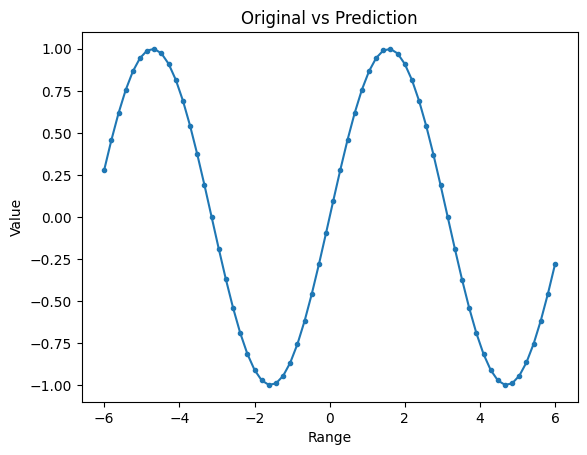

In [4]:
### Generate data set #1
X = np.linspace(-6, 6, n_sample, requires_grad=False)
X = X.reshape((X.shape[0], 1))
y = np.sin(X[:,0], requires_grad=False)

### Switch to data set #2
# X = np.linspace(-6, 6, n_sample, requires_grad=False)
# X = X.reshape((X.shape[0], 1))
# y = (np.sin(0.7*X[:,0]+0.5*np.pi, requires_grad=False)+1.0)*0.5

plt.title('Original vs Prediction')
plt.xlabel('Range')
plt.ylabel('Value')
plt.plot(X[:,0],y,'.-')
plt.show()

---

## <font color="blue">Model development</font>

## Alternative model definitions

In [5]:
### A range of sample models to try (select below)
#   Device based on the lightning qubit could make it faster (not always)
#   Selected differential methods include 'adjoint' and 'parameter-shift' 

dev = qml.device('default.qubit', wires=n_qubits, shots=None)
# dev = qml.device('lightning.qubit', wires=n_qubits, shots=None)

### Simplistic model

<font color="LightCoral">Task 5: Change the data encoding gate from RY to RX.</font>
- <font color="LightCoral">What was the impact of this change on the model performance? Why?</font>
- <font color="LightCoral">Can the performance be further improved by changing the training epochs?</font>

<font color="LightCoral">Task 6: Change entangling from basic (R with 1 param) to strong (R with 3 params).<br>
- <font color="LightCoral">What is the reason for the result ?</font>

<font color="CornflowerBlue">Ensure the ansatz shape matches parameter initialisation!<br>
Cf. sections: "Model visualisation" and "Model initialisation".</font>

In [6]:
@qml.qnode(dev, diff_method='adjoint')
def qnn_model_1(params, x):
    
    # Data encoding
    qml.RY(x, wires=0)
    
    # Ansatz, note:
    #   basic entangling  - 1 trainable parameter / layer per qubit)
    #   strong entangling - 3 trainable parameters / layer per qubit)
    qml.BasicEntanglerLayers(params, wires=range(n_qubits), rotation=qml.RY)
    # qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

### Data reuploading models

<font color="LightCoral">Task 8: Can you improve the result by data reuploading, i.e. by implementing:</font>
- <font color="LightCoral"><strong>partial reuploading:</strong> for all qubits within the encoding block, as in <strong><em>model 2</em></strong> ?</font>
- <font color="LightCoral"><strong>full reuploading:</strong> for all qubits and layers, in between the entangling blocks, as in <strong><em>model 3</em></strong> ?</font>

<font color="CornflowerBlue">When changing the model, make sure to assign the new model name to the variable <strong><em>qnn_model</em></strong>.<br>
See the section immediately following definitions of models <strong><em>qnn_model_2</em></strong> and <strong><em>qnn_model_3</em></strong>.</font>

In [7]:
### Partial data reuploading model
#   Notes: encoding relies on data to be reuploaded into each qubit
#          this model is to be used for the more complex dataset 2
@qml.qnode(dev, diff_method='adjoint')
def qnn_model_2(params, x):

    # Data encoding
    for q in range(n_qubits):
        qml.RY(x, wires=q)
        
    # Ansatz
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [8]:
### Full data reuploading model
#   Notes: encoding parameters are intermixed with trainable parameters
#          this model is to be used for the more complex dataset 2
@qml.qnode(dev, diff_method='parameter-shift')
def qnn_model_3(params, x):
    for l in range(n_layers):
        for q in range(n_qubits):
            qml.RY(x, wires=q)
        qml.StronglyEntanglingLayers([params[l]], wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

### Select the model

In [9]:
qnn_model = qnn_model_1

## Loss and cost function
<font color="CornflowerBlue">Observe that we differentiate the concept of a <strong><em>loss</em></strong> from the <strong><em>cost</em></strong>,
which have many definitions and interpretations.<br>
We consider <em>loss</em> as the error generated at a single data point, wheareas <em>cost</em> as an aggregation of losses across all data points.<br>
In this context, <strong><em>mse_cost</em></strong> is used as an <strong><em>objective function</em></strong> that guides the optimisation process, and which we aim to minimise.<br>
Also note that for the model training purposes, <em>mse_cost</em> defined here cannot be replaced by sklearn <em>mean_squared_error</em>,<br>
as it does not understand gradients. When we switch to PyTorch, we will use its full suite of gradient-aware loss/cost functions.</font>

In [10]:
### Our own gradient-friendly cost function
def mse_cost(targets, predictions):
    cost = 0
    for l, p in zip(targets, predictions):
        loss = (l - p) ** 2
        cost = cost + loss
    cost = cost / len(targets)
    return cost

### Note that this cost function uses global variables
### which is not ideal - we will will show later how to improve this
def cost_fun(params, inputs, targets):
    preds = [qnn_model(params, x) for x in inputs]
    return mse_cost(targets, preds)

## Model visualisation

In [11]:
### Check the shape of your ansatz parameters

print(f'BasicEntanglerLayers shape: {qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)}')
print(f'StronglyEntanglingLayers shape: {qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)}')

BasicEntanglerLayers shape: (4, 2)
StronglyEntanglingLayers shape: (4, 2, 3)


In [12]:
### Check if the model works
### - Note that the shape of test params must match the model

# For reproducibility
np.random.seed(seed)

### Uncomment only the initialisation matching the ansatz (or else you'll get an error)
test_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits), requires_grad=True)
# test_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits, 3), requires_grad=True)
test_data = X[0]
qnn_model(test_params, test_data)

array([-0.05704065])

In [13]:
### Plot the model circuit (in a "standard" text format)
### - Note that in PennyLane many utilities return functions 

print(f"\n{qml.draw(qnn_model, decimals=2, level='device')(test_params, test_data)}\n")


0: ──RY(-6.00)──RY(0.43)─╭●──RY(2.93)─╭●──RY(1.22)─╭●──RY(2.07)─╭●─┤  <Z>
1: ──RY(2.79)────────────╰X──RY(1.40)─╰X──RY(0.81)─╰X──RY(1.55)─╰X─┤     



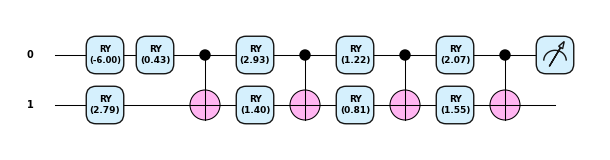

In [14]:
### Plot the model circuit nicely using matplotlib functions
### - Note that a more flexible circuit drawer can be found in utilities.py

qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(qnn_model, decimals=2, level='device')(test_params, test_data)
fig.set_dpi(fig.get_dpi()*0.5)
plt.show()

## Model training

### Model initialisation
<font color="CornflowerBlue">Ensure that the shape of randomly initialised parameters matches exactly the shape of the ansatz!<br>
Comment/uncomment only the required selection of the optimiser and ansatz initialisation.</font>

<font color="LightCoral">Task 2: Change the range of initialisation values.<br>
Replace <strong>high=np.pi</strong> with <strong>high=0.1</strong> then <strong>high=0.01</strong>.</font>

In [15]:
### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

### Select the random initial parameters to match the ansatz shape
init_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits), requires_grad=True)
# init_params = np.random.uniform(high=np.pi, size=(n_layers, n_qubits, 3), requires_grad=True)    

### Training loop

In [16]:
### For reproducibility
np.random.seed(seed)

### Prepare training
hist_cost = []
prompt_fract = 0.1
params = copy.deepcopy(init_params)

### Training loop
start_time = time.time() 
for iter in range(epochs):
    params, cost = opt.step_and_cost(lambda p: cost_fun(p, X, y), params)
    elapsed_time = time.time()-start_time
    hist_cost.append(cost)
    if (prompt_fract == 0) or (iter % int(prompt_fract*epochs) == 0):
        print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost.numpy(), 6)}')

### Print the training summary
min_cost = np.min(hist_cost)
min_iter = np.argmin(hist_cost)
print(f'\nTraining completed: epochs={epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

Iter: 000 (000 sec) cost=[0.625639]
Iter: 002 (000 sec) cost=[0.063659]
Iter: 004 (001 sec) cost=[0.127678]
Iter: 006 (002 sec) cost=[0.070113]
Iter: 008 (002 sec) cost=[0.004349]
Iter: 010 (003 sec) cost=[0.064605]
Iter: 012 (003 sec) cost=[0.028122]
Iter: 014 (004 sec) cost=[0.02237]
Iter: 016 (004 sec) cost=[0.019527]
Iter: 018 (005 sec) cost=[0.006788]

Training completed: epochs=20, min cost=0.001607 @ 15, time=005 secs



## Plot the results
*Note that a more flexible performance and multi-curve plotters can be found in utilities.py*

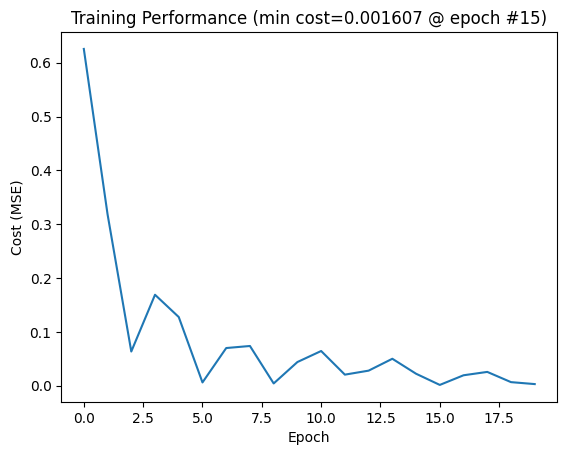

In [17]:
### Show training performance
plt.title(f'Training Performance (min cost={np.round(min_cost, 6)} @ epoch #{min_iter})')
plt.xlabel('Epoch')
plt.ylabel('Cost (MSE)')
plt.plot(hist_cost,'-')
plt.show()

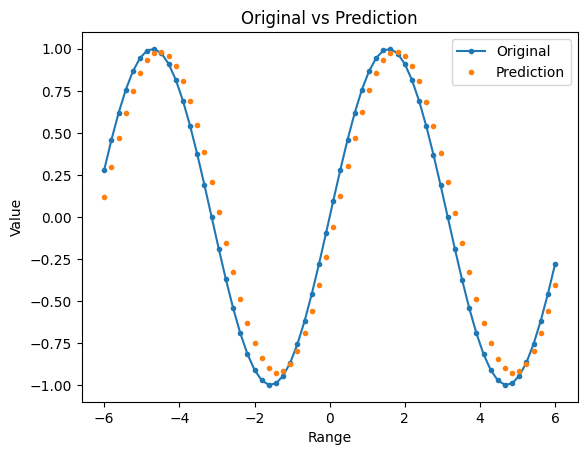

In [18]:
### Plot original vs prediction
y_pred = [qnn_model(params, x) for x in X]

plt.title('Original vs Prediction')
plt.xlabel('Range')
plt.ylabel('Value')
plt.plot(X[:,0], y, '.-', label='Original')
plt.plot(X[:,0], y_pred, '.', label='Prediction')
plt.legend(loc='best', ncol=1)
plt.show()

---

## <font color="blue">Challenge task:</font><br>Write your own optimiser (in own time)
**You can try using this Random Coordinate Descent (RCD) optimiser**<br>
*RCD is a gradient-based optimizer, so it uses the gradient of the cost function.<br>
This method updates one random parameter at the time, so it is very slow!<br>
However, think what would be the advantages of this approach!*<br/>
Ref: https://pennylane.ai/blog/2022/07/how-to-create-your-own-optimizer

In [19]:
class RCDOptimizer:
    def __init__(self, eta=0.01 , h=0.005):
        self.h = h
        self.eta = eta

    def step(self, objective_fn, theta):
        i = np.random.randint(theta.size)
        shape = theta.shape
        dt = np.eye(1,theta.size,i)
        theta = theta.reshape(-1)
        dtheta = (objective_fn((theta+dt*self.h).reshape(shape)) 
                    -objective_fn((theta-dt*self.h).reshape(shape)))/(2*self.h)
        return (theta - self.eta*dtheta*dt).reshape(shape)

    def step_and_cost(self, objective_fn, theta):
        theta = self.step(objective_fn, theta)
        return theta, objective_fn(theta)

---

## Write your observations here

- Task 1:
- Task 2:
- Task 3:
- Task 4:
- Task 5:
- Task 6:
- Task 7:
- Challenge:
- Reflection:

## Software (Linux)

In [20]:
import os
os.system('pip list | grep -e PennyLane -e torch');

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
PennyLane_Lightning_GPU   0.40.0
torch                     2.6.0
torchaudio                2.6.0
torcheval                 0.0.7
torchmetrics              1.6.1
torchsummary              1.5.1
torchvision               0.21.0
